## Train small Conv network on MNIST

In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchinfo import summary
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [58]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization
class CNN1(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # fully connected layer, output 10 classes
        self.flatten = nn.Flatten(1,3)
        self.out = nn.Linear(28 * 28, 10)
    def forward(self, x):
        # flatten the output of conv2 to (batch_size, 28 * 28 * 3)
        x = self.flatten(x)     
        output = self.out(x)
        return output    # return x for visualization

In [59]:
# net = CNN()
net = MLP()
net.to(device)
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [61]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=False)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=False)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [62]:
PATH = './model/mnist_MLP.pth'
TRAIN = not os.path.isfile(PATH)
if TRAIN:
    for epoch in range(1):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(train_loader, 0), total = len(train_loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
else:
    net = torch.load(PATH)
    net.to(device)

  0%|          | 0/600 [00:00<?, ?it/s]

[1,     1] loss: 0.001
[1,   501] loss: 0.306
Finished Training


In [63]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 85 %


## Convert model using hls4ml

In [22]:
import hls4ml
config = hls4ml.utils.config_from_pytorch_model(net, granularity='name')
print("-----------------------------------")
print(config)
print("-----------------------------------")

-----------------------------------
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
-----------------------------------


In [48]:
net = net.to('cpu')
hls_model = hls4ml.converters.convert_from_pytorch_model(net, input_shape=([1,1,28,28]),
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj_2',
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()

Interpreting Model ...
Topology:
Input Shape:  [[1, 1, 28, 28]]
Layer name: out, layer type: Dense, input shape: [[1, 1, 28, 28]]
Creating HLS model
Writing HLS project
Done


In [72]:
# correct = 0
# total = 0
# sample = next(iter(test_loader))
# X_test = [i for i in sample[0]]
# y_test = [i for i in sample[1]]
# # since we're not training, we don't need to calculate the gradients for our outputs
# for data in zip(X_test, y_test):
#     images, labels = data
#     images, labels = images.numpy(), labels.numpy()
#     # calculate outputs by running images through the network
#     outputs = hls_model.predict(images)
#     # the class with the highest energy is what we choose as prediction
#     predicted = np.max(outputs,1)
#     total += labels.size
#     correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [50]:
images.shape

(1, 28, 28)

In [73]:
sample = next(iter(test_loader))
X_test = [i for i in sample[0]]
y_test = [i for i in sample[1]]

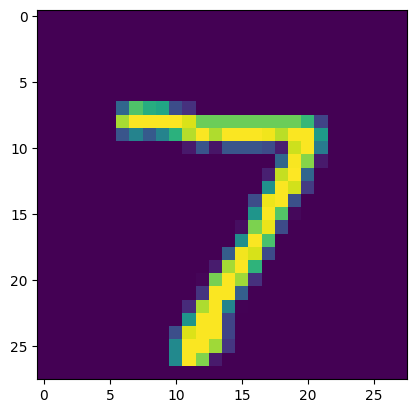

In [74]:
test_sample = X_test[0][0].numpy()
plt.imshow(test_sample)

In [70]:
y = hls_model.predict(test_sample)

In [71]:
y.shape

(280,)

## Go through (Q)ONNX

In [21]:
# # Input to the model
# x = next(iter(test_loader))[0]
# x = x.to(device)
# torch_out = net(x)

# # Export the model
# torch.onnx.export(net,               # model being run
#                   x,                         # model input (or a tuple for multiple inputs)
#                   "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})